<a href="https://colab.research.google.com/github/LenaVolzhina/playing-with-neural-networks/blob/master/DL_chapter_3_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Данные

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Полученные данные уже разбиты на тренировочную (`mnist.train`), тестовую
(`mnist.test`) и валидационную (`mnist.validate`) выборки, содержащие 55 000, 10 000
и 5000 примеров соответственно. Каждая из этих выборок состоит из изображений цифр (`mnist.train.images`) и их меток (`mnist.train.labels`)

In [0]:
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
mnist.train.images.shape

(55000, 784)

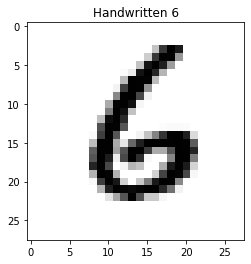

In [5]:
def plot_image(image, title, ax=None):
  image_reshaped = (1 - image).reshape((28, 28))
  if ax:
    ax.imshow(image_reshaped, cmap=plt.get_cmap('gray'))
    ax.set_title(title)
  else:
    plt.imshow(image_reshaped, cmap=plt.get_cmap('gray'))
    plt.title(title)

idx = 1000
plot_image(mnist.train.images[idx], 'Handwritten {}'.format(np.argmax(mnist.train.labels[idx])))

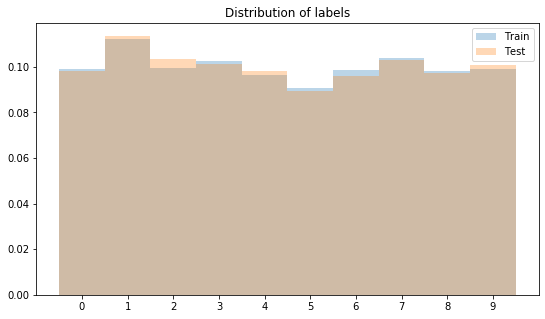

In [6]:
def simple_hist(data, label):
  return plt.hist(
      data, alpha=0.3, label=label, 
      density=True, bins=np.arange(11) - 0.5
  )

plt.figure(figsize=(9, 5))

simple_hist(np.argmax(mnist.train.labels, axis=1), 'Train')
simple_hist(np.argmax(mnist.test.labels, axis=1), 'Test')

plt.title('Distribution of labels')
plt.xticks(np.arange(10))     # show all ticks
_ = plt.legend()

## Посмотрим на усреднённые картинки для каждой метки

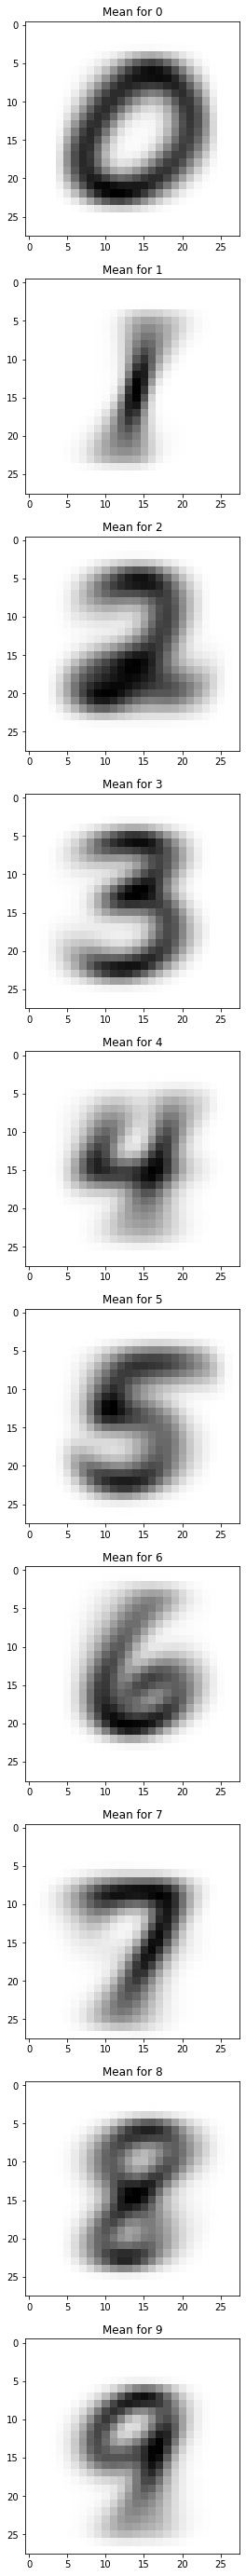

In [7]:
_, axes = plt.subplots(nrows=10, figsize=(5, 10 * 5))
for ax, digit in zip(axes, range(10)):
  indices = np.argmax(mnist.train.labels, axis=1) == digit
  images = mnist.train.images[indices]
  plot_image(images.mean(axis=0), 'Mean for {}'.format(digit), ax=ax)

# Как будем обучать

В качестве модели для обучения мы рассмотрим **softmax-регрессию**.

Это обобщение логистической регрессии на случай нескольких классов: чтобы получить
«вероятности» классов, которые нам хочется оценить, мы применяем так называемую softmax-функцию к вектору получившихся ненормализованных оценок


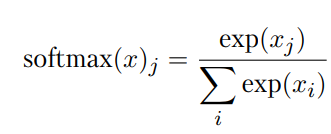

В качестве функции потерь мы будем использовать стандартную для логистической регрессии **перекрестную энтропию** (кросс-энтропию, cross-entropy):

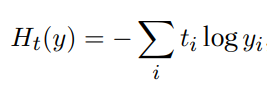

In [0]:
# переменная для тренировочных данных
# размерность None позволяет использовать произвольное число векторов
x = tf.placeholder(tf.float32, [None, 784])

In [0]:
# изменяющиеся при обучении переменные
# собираемся умножать вектор размерности 784 на W
# и получать предсказание для 10 возможных меток
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

In [0]:
# а вот и наша модель!
y = tf.nn.softmax(tf.matmul(x, W) + b)

In [0]:
# а так мы будем оценивать качество предсказаний

# заглушка для истинной разметки
y_ = tf.placeholder(tf.float32, [None, 10])

# функция потерь
cross_entropy = tf.reduce_mean(
  -tf.reduce_sum(
      y_ * tf.log(y), 
      reduction_indices=[1]   # суммируем по размерности y, а не по примерам
  )
)

Общая схема обучения:
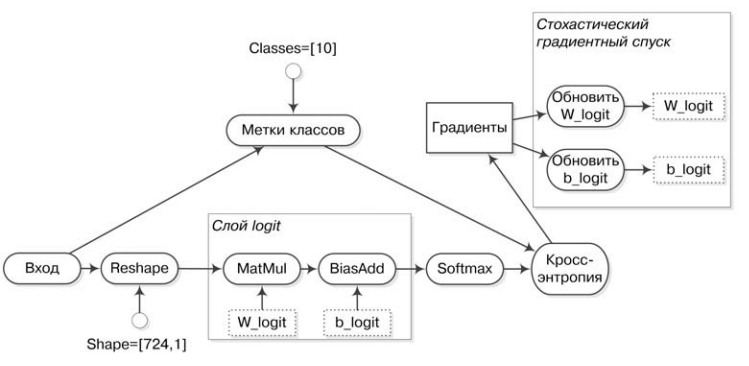

In [0]:
# шаг обучения
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [0]:
# обучение
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

In [0]:
for i in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

In [15]:
# метрика точности
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
accuracy_calc = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
print("Точность: {:.4f}".format(accuracy_calc))

Точность: 0.9184


### Интересно что-нибудь узнать про прообраз каждого класса

Так как у нас ровно один слой с линейной суммацией, можно просто нарисовать веса, соответствующие каждому выходу

In [19]:
weights = W.eval(session=sess)
bias = b.eval(session=sess)
weights.shape, bias.shape

((784, 10), (10,))

In [20]:
bias

array([-0.37960708,  0.3407091 ,  0.13119099, -0.28361893, -0.002007  ,
        1.2754537 , -0.0681573 ,  0.6338149 , -1.4193593 , -0.22841813],
      dtype=float32)

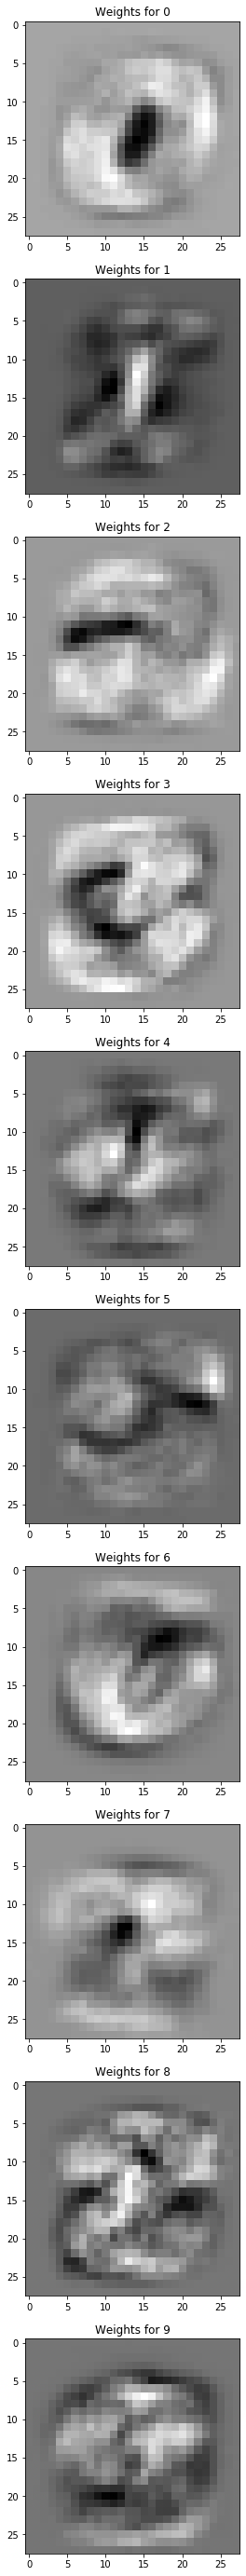

In [17]:
_, axes = plt.subplots(nrows=10, figsize=(5, 10 * 5))
for ax, digit in zip(axes, range(10)):
  plot_image(weights[:, digit], f'Weights for {digit}', ax=ax)

Можно рассмотреть, какие области сетка считает аргументами "за" цифру (они светлее, чем фон), а какие "против" (соответственно, темнее).

У ноля прям крутая дырка внутри. И у единицы видна вертикальная палочка. Тройка тоже угадывается, остальные более сложные

И еще сразу становится понятно, насколько модель использует то, что цифры на картинке отцентрованы.
 


# Теперь сделаем сеть со скрытым слоем

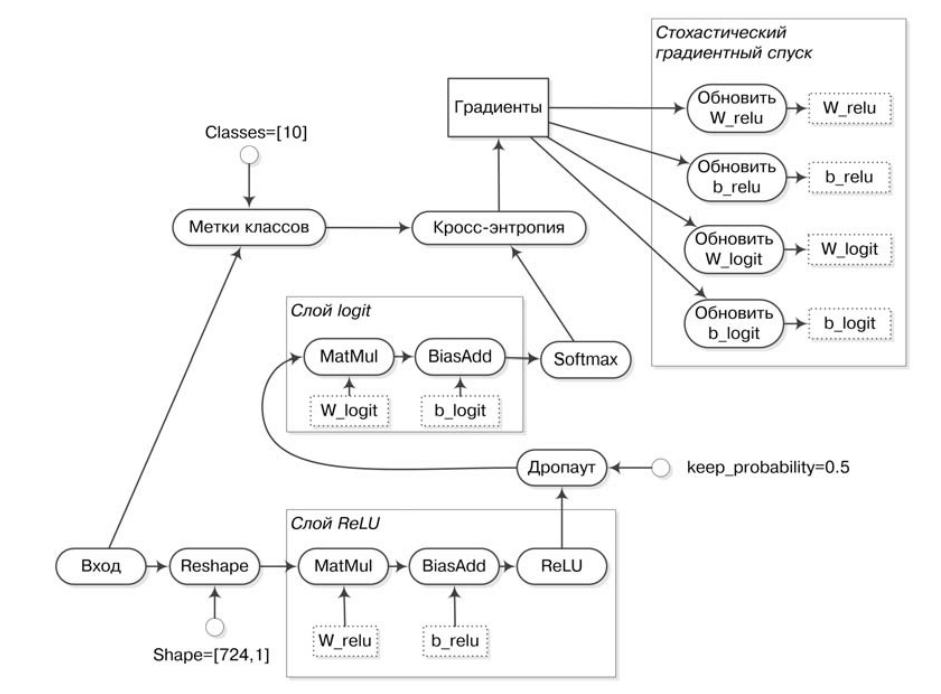

In [0]:
# переменная для тренировочных данных
# размерность None позволяет использовать произвольное число векторов
x = tf.placeholder(tf.float32, [None, 784])

# изменяющиеся при обучении переменные, до этого начинали из нулей
# а почему вообще-то и тут нельзя? неочевидна разница TODO
W_relu = tf.Variable(tf.truncated_normal([784, 100], stddev=0.1))
b_relu = tf.Variable(tf.truncated_normal([100], stddev=0.1))

# скрытый слой
h = tf.nn.relu(tf.matmul(x, W_relu) + b_relu)

# дропаут
keep_probability = tf.placeholder(tf.float32)     # вероятность
h_drop = tf.nn.dropout(h, keep_probability)

# выходной слой
W = tf.Variable(tf.zeros([100, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(h_drop, W) + b)


# дальше ничего не меняется

# заглушка для истинной разметки
y_ = tf.placeholder(tf.float32, [None, 10])

# функция потерь
cross_entropy = tf.reduce_mean(
  -tf.reduce_sum(
      y_ * tf.log(y), 
      reduction_indices=[1]   # суммируем по размерности y, а не по примерам
  )
)

# шаг обучения
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# обучение
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

In [0]:
for i in range(2000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={
      x: batch_xs, y_: batch_ys,
      keep_probability: 0.5}
  )

In [0]:
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
accuracy_calc = sess.run(accuracy, feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_probability: 1.
})

print(f"Точность: {accuracy_calc:.4f}")

Точность: 0.9650


Доучим ещё 100500 шагов

In [0]:
for i in range(10000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={
      x: batch_xs, y_: batch_ys,
      keep_probability: 0.5}
  )

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
accuracy_calc = sess.run(accuracy, feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_probability: 1.
})

print(f"Точность: {accuracy_calc:.4f}")

Точность: 0.0980


# Как описать кросс-энтропию, чтобы не переполняться

In [0]:
from datetime import datetime

import tensorflow as tf

### Повторяю всё, потому что перешла на GPU

In [0]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [0]:
# переменная для тренировочных данных
# размерность None позволяет использовать произвольное число векторов
x = tf.placeholder(tf.float32, [None, 784])

# изменяющиеся при обучении переменные, до этого начинали из нулей
# а почему вообще-то и тут нельзя? неочевидна разница TODO
W_relu = tf.Variable(tf.truncated_normal([784, 100], stddev=0.1))
b_relu = tf.Variable(tf.truncated_normal([100], stddev=0.1))

# скрытый слой
h = tf.nn.relu(tf.matmul(x, W_relu) + b_relu)

# дропаут
keep_probability = tf.placeholder(tf.float32)     # вероятность
h_drop = tf.nn.dropout(h, keep_probability)

# выходной слой
W = tf.Variable(tf.zeros([100, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(h_drop, W) + b)


# дальше ничего не меняется

# заглушка для истинной разметки
y_ = tf.placeholder(tf.float32, [None, 10])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Возвращаюсь к интересному

In [0]:
# функция потерь
logit = tf.matmul(h_drop, W) + b
cross_entropy_better = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logit, labels=y_)
)

# шаг обучения
train_step_better = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy_better)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
# обучение
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)


accuracy_history = {'train': [], 'test': []}
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def calc_accuracy(session, ds):  
  accuracy_calc = session.run(accuracy, feed_dict={
      x: ds.images, y_: ds.labels, keep_probability: 1.
  })
  return accuracy_calc


for i in range(20000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step_better, feed_dict={
      x: batch_xs, y_: batch_ys,
      keep_probability: 0.5}
  )
  if (i + 1) % 200 == 0:
    acc_train = calc_accuracy(sess, mnist.train)
    acc_test = calc_accuracy(sess, mnist.test)
    accuracy_history['train'].append(acc_train)
    accuracy_history['test'].append(acc_test)
  
    print(f"[{datetime.now()}] Step {i + 1}, train accuracy {acc_train:.4f}, test accuracy {acc_test:.4f}")

[2019-11-15 19:46:04.456458] Step 200, train accuracy 0.9150, test accuracy 0.9162
[2019-11-15 19:46:04.903964] Step 400, train accuracy 0.9362, test accuracy 0.9361
[2019-11-15 19:46:05.304556] Step 600, train accuracy 0.9462, test accuracy 0.9452
[2019-11-15 19:46:05.767739] Step 800, train accuracy 0.9516, test accuracy 0.9486
[2019-11-15 19:46:06.162259] Step 1000, train accuracy 0.9518, test accuracy 0.9493
[2019-11-15 19:46:06.559218] Step 1200, train accuracy 0.9598, test accuracy 0.9568
[2019-11-15 19:46:07.002466] Step 1400, train accuracy 0.9617, test accuracy 0.9560
[2019-11-15 19:46:07.413428] Step 1600, train accuracy 0.9642, test accuracy 0.9617
[2019-11-15 19:46:07.793738] Step 1800, train accuracy 0.9667, test accuracy 0.9621
[2019-11-15 19:46:08.228507] Step 2000, train accuracy 0.9691, test accuracy 0.9651
[2019-11-15 19:46:08.628796] Step 2200, train accuracy 0.9690, test accuracy 0.9644
[2019-11-15 19:46:09.046655] Step 2400, train accuracy 0.9691, test accuracy 0.9

In [0]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Text(0.5, 1.0, 'Accuracy of ReLU model by epoch')

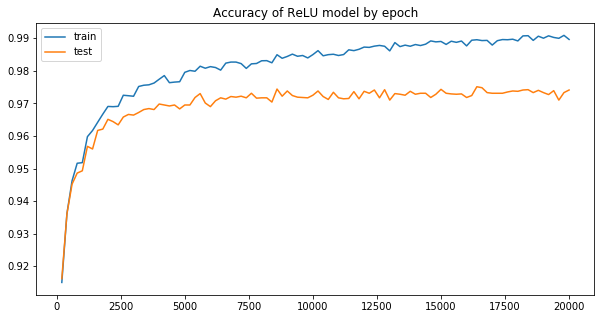

In [0]:
plt.figure(figsize=(10, 5))

xs = np.arange(200, 20000 + 1, 200)
ys_train = np.array(accuracy_history['train'])
ys_test = np.array(accuracy_history['test'])

plt.plot(xs, ys_train, '-', label='train')
plt.plot(xs, ys_test, '-', label='test')
plt.legend()
plt.title('Accuracy of ReLU model by epoch')